# PSDs (L5)

purpose: compare the Marques data with the models (Layer 5 only because Buccino models L5).

### Setup 

activate spikeinterf ...

In [29]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
import spikeinterface.extractors as se
import scipy
from scipy.optimize import minimize
import spikeinterface.full as si_full
from concurrent.futures import ProcessPoolExecutor
import scipy

from scipy import signal


# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config

matplotlib.rcParams['agg.path.chunksize'] = 10000

# SETUP PARAMETERS
# sampling frequency
SFREQ_VIVO = 30000         
SFREQ_SILICO = 40000
SFREQ_BUCCI = 32000

# DATASET COMFIG
# vivo
data_conf_vivo, param_conf_h_vivo = get_config("vivo_marques", "c26").values()
RAW_PATH_vivo = data_conf_vivo["probe_wiring"]["output"]
PREP_PATH_vivo = data_conf_vivo["preprocessing"]["output"]["trace_file_path"]
RAW_TRACES_VIVO = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/dataeng/1_vivo/marques/campaign/c26_fixed/traces_in_ctx_10m_noise_fitd.npy"
PREP_TRACES_VIVO = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/preprocessed/1_vivo/marques/campaign/c26_fixed/traces_in_ctx_10m_noise_fitd.npy"
RAW_PSD_VIVO = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/realism/1_vivo/marques/c26_fixed/postpro/full_raw_power_welch_10m.npy"
PREP_PSD_VIVO = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/realism/1_vivo/marques/c26_fixed/postpro/full_prep_buttw_power_welch_10m.npy"

# biophy
data_conf_sili, param_conf_sili = get_config(
    "silico_neuropixels", "concatenated"
).values()
RAW_PATH_sili = data_conf_sili["probe_wiring"]["output"]
PREP_PATH_sili = data_conf_sili["preprocessing"]["output"]["trace_file_path"]
RAW_TRACES_SILI = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/0_silico/neuropixels/concatenated_campaigns/dataeng/recording/traces_in_ctx_10m_noise_fitd.npy"
PREP_TRACES_SILI = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/0_silico/neuropixels/concatenated_campaigns/preprocessed/traces_in_ctx_10m_noise_fitd.npy"
RAW_PSD_SILI = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/0_silico/neuropixels/concatenated_campaigns/postpro/realism/lfp/full_raw_power_welch_10m.npy"
PREP_PSD_SILI = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/0_silico/neuropixels/concatenated_campaigns/postpro/realism/lfp/full_prep_buttw_power_welch_10m.npy"

# hybrid (Buccino)
data_conf_bucci, param_conf_bucci = get_config("buccino_2020", "2020").values()
RAW_RECEX_bucci = data_conf_bucci["probe_wiring"]["output"]
PREP_RECEX_bucci = data_conf_bucci["preprocessing"]["output"]["trace_file_path"]
RAW_TRACES_BUCCI = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/dataeng/hybrid/buccino/recording/traces_10m.npy"
PREP_TRACES_BUCCI = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/dataeng/hybrid/buccino/preprocessed/traces_10m.npy"
RAW_PSD_BUCCI = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/postprocessing/hybrid/buccino/realism/lfp/raw_power_welch_10m.npy"
PREP_PSD_BUCCI = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/postprocessing/hybrid/buccino/realism/lfp/prep_buttw_power_welch_10m.npy"

# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
COLOR_BUCCI = (0, 0.5, 1)
BOX_ASPECT = 1                  # square fig
LG_FRAMEON = False              # no legend frame
FIG_SIZE = (8, 3)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 30
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
N_MAJOR_TICKS = 3
N_MINOR_TICKS = 12
YLIM = [1e-7, 1e8]
savefig_cfg = {"transparent":True}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-05-15 16:02:33,189 - root - utils.py - get_config - INFO - Reading experiment config.
2024-05-15 16:02:33,234 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-05-15 16:02:33,235 - root - utils.py - get_config - INFO - Reading experiment config.
2024-05-15 16:02:33,272 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-05-15 16:02:33,273 - root - utils.py - get_config - INFO - Reading experiment config.
2024-05-15 16:02:33,293 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Custom functions

In [ ]:
def plot_power_for_layer(
    layer: str,
    site_layers_sili: list,
    site_layers_vivo: list,
    out_raw_vivo: dict,
    out_raw_sili: dict,
):
    """plot power spectrum density for the
    specified layer

    Args:
        layer (str): layer "L1", "L2_3", "L4", "L5", "L6"
        site_layers_sili (list): layers of each in silico sites
        site_layers_vivo (list): layers of each in vivo sites
        out_raw_vivo (dict): _description_
        out_raw_sili (dict): _description_
    """

    fig, axes = plt.subplots(1, 2, figsize=FIG_SIZE)

    # Select traces in layer

    # raw
    raw_power_sili_layer_i = out_raw_sili["power"][site_layers_sili == layer, :]
    raw_power_vivo_layer_i = out_raw_vivo["power"][site_layers_vivo == layer, :]

    # preprocessed
    prep_power_sili_layer_i = out_prep_sili["power"][site_layers_sili == layer, :]
    prep_power_vivo_layer_i = out_prep_vivo["power"][site_layers_vivo == layer, :]

    # Raw panel --------------------------------

    # VIVO
    psd_mean = np.mean(raw_power_vivo_layer_i, axis=0)
    axes[0].plot(
        out_raw_vivo["freq"],
        psd_mean,  # / psd_mean.mean(),
        color=COLOR_VIVO,
        label="vivo",
    )

    # SILICO
    psd_mean = np.mean(raw_power_sili_layer_i, axis=0)
    axes[0].plot(
        out_raw_sili["freq"],
        psd_mean,  # / np.mean(psd_mean),
        color=COLOR_SILI,
        label="silico",
    )

    # legend
    axes[0].set_xlabel("Frequency (Hz)")
    axes[0].set_xlabel("")
    # axes[0].set_ylabel("Power (ratio)")
    # axes[0].set_yscale("log")
    axes[0].set_xscale("log")
    axes[0].spines[["right", "top"]].set_visible(False)
    axes[0].set_ylim(YLIM_R)
    axes[0].set_xlim([-1, SFREQ_SILICO / 2])
    axes[0].tick_params(axis="x", which="minor", colors="black")
    axes[0].tick_params(axis="x", which="major", colors="black")

    # show minor ticks
    locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    locmin = matplotlib.ticker.LogLocator(
        base=10.0,
        subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
        numticks=N_MINOR_TICKS,
    )
    axes[0].tick_params(which="both")
    axes[0].xaxis.set_major_locator(locmaj)
    axes[0].xaxis.set_minor_locator(locmin)
    axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    # axes[0].set_xticklabels([])

    # # show minor ticks
    # locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    # locmin = matplotlib.ticker.LogLocator(
    #     base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=N_MINOR_TICKS
    # )
    # axes[0].tick_params(which="both", width=1)
    # axes[0].xaxis.set_major_locator(locmaj)
    # axes[0].xaxis.set_minor_locator(locmin)
    # axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    # Preprocessed panel --------------------------------

    # VIVO
    psd_mean = np.mean(prep_power_vivo_layer_i, axis=0)
    axes[1].plot(
        out_prep_vivo["freq"],
        psd_mean,  # / np.mean(psd_mean),
        color=COLOR_VIVO,
        label="vivo",
    )

    # SILICO
    psd_mean = np.mean(prep_power_sili_layer_i, axis=0)
    axes[1].plot(
        out_prep_sili["freq"],
        psd_mean,  # / np.mean(psd_mean),
        color=COLOR_SILI,
        label="silico",
    )

    # legend
    # axes[1].set_xlabel("Frequency (Hz)")
    axes[1].set_xlabel("")
    axes[1].set_xscale("log")
    axes[1].spines[["left", "right", "top"]].set_visible(False)
    axes[1].set_yticklabels([])
    axes[1].set_yticks([])
    axes[1].set_xticks([])
    # axes[1].legend(**legend_cfg)
    axes[1].set_ylim(YLIM_P)

    # # show minor ticks
    # locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    # locmin = matplotlib.ticker.LogLocator(
    #     base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=N_MINOR_TICKS
    # )
    # axes[1].tick_params(which="both", width=1)
    # axes[1].xaxis.set_major_locator(locmaj)
    # axes[1].xaxis.set_minor_locator(locmin)
    # axes[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    axes[1].set_xlim([-1, SFREQ_SILICO / 2])
    axes[1].tick_params(axis="x", which="minor", colors="black")
    axes[1].tick_params(axis="x", which="major", colors="black")

    # show minor ticks
    locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    locmin = matplotlib.ticker.LogLocator(
        base=10.0,
        subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
        numticks=N_MINOR_TICKS,
    )
    axes[1].tick_params(which="both")
    axes[1].xaxis.set_major_locator(locmaj)
    axes[1].xaxis.set_minor_locator(locmin)
    axes[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    # axes[0].set_xticklabels([])

    fig.tight_layout(**tight_layout_cfg)
    return axes

In [25]:
# get layers
layers = ["L1", "L2_3", "L4", "L5", "L6"]

# vivo
RawVivo = si.load_extractor(RAW_PATH_vivo)
PreprocessedVivo = si.load_extractor(PREP_PATH_vivo)
site_layers_vivo = RawVivo.get_property("layers")
IN_CTX = np.isin(site_layers_vivo, layers)
sites_vivo = np.where(IN_CTX)[0]

# silico
RawSili = si.load_extractor(RAW_PATH_sili)
PreprocessedSili = si.load_extractor(PREP_PATH_sili)
site_layers_sili = RawSili.get_property("layers")
site_layers_sili = [
    "L2_3" if l_i == "L2" or l_i == "L3" else l_i for l_i in site_layers_sili
]
IN_CTX = np.isin(site_layers_sili, layers)
sites_sili = np.where(IN_CTX)[0]

# keep only the layers
site_lyr_s = np.array(site_layers_sili)[sites_sili]
site_lyr_v = np.array(site_layers_vivo)[sites_vivo]

In [14]:
# load vivo traces and psd
raw_traces_vivo = np.load(RAW_TRACES_VIVO, allow_pickle=True)
prep_traces_vivo = np.load(PREP_TRACES_VIVO, allow_pickle=True)
out_raw_vivo = np.load(RAW_PSD_VIVO, allow_pickle=True).item()
out_prep_vivo = np.load(PREP_PSD_VIVO, allow_pickle=True).item()

# load vivo traces and psd
raw_traces_sili = np.load(RAW_TRACES_SILI, allow_pickle=True)
prep_traces_sili = np.load(PREP_TRACES_SILI, allow_pickle=True)
out_raw_sili = np.load(RAW_PSD_SILI, allow_pickle=True).item()
out_prep_sili = np.load(PREP_PSD_SILI, allow_pickle=True).item()

# load Bucci traces and psd
raw_traces_bucci = np.load(RAW_TRACES_BUCCI, allow_pickle=True)
prep_traces_bucci = np.load(PREP_TRACES_BUCCI, allow_pickle=True)
out_raw_bucci = np.load(RAW_PSD_BUCCI, allow_pickle=True).item()
out_prep_bucci = np.load(PREP_PSD_BUCCI, allow_pickle=True).item()

In [16]:
# unit-test
assert out_raw_vivo["freq"][1] == 1.0, "resolution should be 1Hz"
assert out_raw_sili["freq"][1] == 1.0, "resolution should be 1Hz"

In [27]:
LYR = "L5"

# (11s) median over sites
psd_mean_raw_vivo = np.median(out_raw_vivo["power"][site_lyr_v == LYR, :], axis=0)
psd_mean_prep_vivo = np.median(out_prep_vivo["power"][site_lyr_v == LYR, :], axis=0)

psd_mean_raw_sili = np.median(out_raw_sili["power"][site_lyr_s == LYR, :], axis=0)
psd_mean_prep_sili = np.median(out_prep_sili["power"][site_lyr_s == LYR, :], axis=0)

psd_mean_raw_bucci = np.median(out_raw_bucci["power"], axis=0)
psd_mean_prep_bucci = np.median(out_prep_bucci["power"], axis=0)

# confidence intervals
n_samples = out_raw_vivo["power"].shape[0]
ci_raw_vivo = (
    1.96
    * np.std(out_raw_vivo["power"][site_lyr_v == LYR, :], axis=0)
    / np.sqrt(n_samples)
)
ci_prep_vivo = (
    1.96
    * np.std(out_prep_vivo["power"][site_lyr_v == LYR, :], axis=0)
    / np.sqrt(n_samples)
)

n_samples = out_raw_sili["power"].shape[0]
ci_raw_sili = (
    1.96
    * np.std(out_raw_sili["power"][site_lyr_s == LYR, :], axis=0)
    / np.sqrt(n_samples)
)
ci_prep_sili = (
    1.96
    * np.std(out_prep_sili["power"][site_lyr_s == LYR, :], axis=0)
    / np.sqrt(n_samples)
)

n_samples = out_raw_bucci["power"].shape[0]
ci_raw_bucci = 1.96 * np.std(out_raw_bucci["power"], axis=0) / np.sqrt(n_samples)
ci_prep_bucci = 1.96 * np.std(out_prep_bucci["power"], axis=0) / np.sqrt(n_samples)

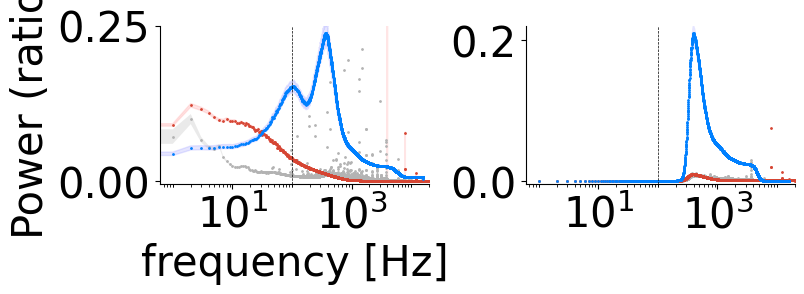

In [37]:
# takes 2 mins
YLIM_R = [-0.005, 0.25]
YLIM_P = [-0.005, 0.22]
N_MAJOR_TICKS = 4
SIZE = 1
fig, axes = plt.subplots(1, 2, figsize=FIG_SIZE)

# Raw panel (8 secs) --------------------------------

# VIVO

# 3 secs
axes[0].plot(
    out_raw_vivo["freq"],
    psd_mean_raw_vivo,
    linestyle="none",
    marker="o",
    markersize=SIZE,
    color=COLOR_VIVO,
    label="vivo",
)
axes[0].plot(
    out_raw_sili["freq"],
    psd_mean_raw_sili,
    color=COLOR_SILI,
    linestyle="none",
    marker="o",
    markersize=SIZE,
    label="silico",
)
axes[0].plot(
    out_raw_bucci["freq"],
    psd_mean_raw_bucci,
    color=COLOR_BUCCI,
    linestyle="none",
    marker="o",
    markersize=SIZE,
    label="silico",
)


# confidence interval
axes[0].fill_between(
    out_raw_vivo["freq"],
    (psd_mean_raw_vivo - ci_raw_vivo),
    (psd_mean_raw_vivo + ci_raw_vivo),
    color=[0.6, 0.6, 0.6],
    linewidth=0,
    alpha=0.2,
)
axes[0].fill_between(
    out_raw_sili["freq"],
    (psd_mean_raw_sili - ci_raw_sili),
    (psd_mean_raw_sili + ci_raw_sili),
    color=[1, 0.5, 0.5],
    linewidth=1,
    alpha=0.2,
)
axes[0].fill_between(
    out_raw_bucci["freq"],
    (psd_mean_raw_bucci - ci_raw_bucci),
    (psd_mean_raw_bucci + ci_raw_bucci),
    color=[0.5, 0.5, 1],
    linewidth=1,
    alpha=0.2,
)


# STATS: mark pvalues < 0.05
# x = out_raw_vivo["freq"][np.where(pvalues005_raw == 1)[0]]
# y = pvalues005_raw[np.where(pvalues005_raw == 1)[0]] * YLIM_R[1]
# axes[0].plot(x, y, "k.", markersize=1)

# 100 Hz (LFP)
axes[0].vlines(
    x=100, ymin=YLIM_R[0], ymax=YLIM_R[1], linestyle="--", color="k", linewidth=0.5
)

# legend
axes[0].set_xscale("log")
axes[0].set_xlim([0, SFREQ_SILICO / 2])
axes[0].set_xlabel("frequency [Hz]")
axes[0].set_ylim(YLIM_R)
axes[0].set_ylabel("Power (ratio)")
axes[0].spines[["right", "top"]].set_visible(False)
axes[0].tick_params(axis="x", which="minor", colors="black")
axes[0].tick_params(axis="x", which="major", colors="black")

# show minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    numticks=N_MINOR_TICKS,
)
axes[0].tick_params(which="both")
axes[0].xaxis.set_major_locator(locmaj)
axes[0].xaxis.set_minor_locator(locmin)
axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# axes[0].set_xticklabels([])

# Preprocessed panel ************************************************************
axes[1].plot(
    out_prep_vivo["freq"],
    psd_mean_prep_vivo,
    linestyle="none",
    marker="o",
    markersize=SIZE,
    color=COLOR_VIVO,
    label="vivo",
)
axes[1].plot(
    out_prep_sili["freq"],
    psd_mean_prep_sili,
    linestyle="none",
    marker="o",
    markersize=SIZE,
    color=COLOR_SILI,
    label="silico",
)
axes[1].plot(
    out_prep_bucci["freq"],
    psd_mean_prep_bucci,
    linestyle="none",
    marker="o",
    markersize=SIZE,
    color=COLOR_BUCCI,
    label="silico",
)

# confidence interval
axes[1].fill_between(
    out_prep_vivo["freq"],
    (psd_mean_prep_vivo - ci_prep_vivo),
    (psd_mean_prep_vivo + ci_prep_vivo),
    color=[0.6, 0.6, 0.6],
    linewidth=0,
    alpha=0.2,
)
axes[1].fill_between(
    out_prep_sili["freq"],
    (psd_mean_prep_sili - ci_prep_sili),
    (psd_mean_prep_sili + ci_prep_sili),
    color=[1, 0.5, 0.5],
    linewidth=0,
    alpha=0.2,
)
axes[1].fill_between(
    out_prep_bucci["freq"],
    (psd_mean_prep_bucci - ci_prep_bucci),
    (psd_mean_prep_bucci + ci_prep_bucci),
    color=[0.5, 0.5, 1],
    linewidth=0,
    alpha=0.2,
)

# mark pvalues < 0.05
# x = out_prep_vivo["freq"][np.where(pvalues005_prep == 1)[0]]
# y = pvalues005_prep[np.where(pvalues005_prep == 1)[0]] * YLIM_P[1]
# axes[1].plot(x, y, "k.", markersize=1)

# 100 Hz (LFP)
axes[1].vlines(
    x=100, ymin=YLIM_P[0], ymax=YLIM_P[1], linestyle="--", color="k", linewidth=0.5
)

# legend
axes[1].set_xscale("log")
axes[1].spines[["right", "top"]].set_visible(False)
axes[1].legend(**legend_cfg)

# show minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    numticks=N_MINOR_TICKS,
)
axes[1].tick_params(which="both")
axes[1].xaxis.set_major_locator(locmaj)
axes[1].xaxis.set_minor_locator(locmin)
axes[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
axes[1].set_ylim(YLIM_P)
axes[1].set_xlim([-1, SFREQ_SILICO / 2])

fig.tight_layout(**tight_layout_cfg)

# clear legend
axes[1].get_legend().remove()

# save (12MB figure)
plt.savefig(
    "figures/2_realism/4_power/svg/marques/compare_marques_with_models_10m_psd_layer5_raw_welch_and_stats.svg",
    **savefig_cfg
)